### Import Important Library Files

In [11]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

### Data Preparation And Pre-processing

In [12]:
# Define the path to your dataset
data_dir = 'dataset_24-2/dataset_24-2'

In [13]:
# Define transformations for pre-processing
transform = transforms.Compose([
    transforms.CenterCrop((200, 200)),  # Crop the center of 200x200 pixels
    transforms.Resize((224, 224)),      # Resize to 224x224 pixels
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [14]:
# Load dataset using ImageFolder
dataset = ImageFolder(data_dir, transform=transform)

In [15]:
# Split dataset into training (80%) and testing (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [16]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
# Specify class names
class_names = dataset.classes
num_classes = len(class_names)

In [18]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Model Definition 

In [19]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet model
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
model = model.to(device)


### Model Training

In [20]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save model weights
torch.save(model.state_dict(), 'resnet_model.pth')


Epoch [1/10], Loss: 0.8603
Epoch [2/10], Loss: 0.5040
Epoch [3/10], Loss: 0.2822
Epoch [4/10], Loss: 0.1875
Epoch [5/10], Loss: 0.1435
Epoch [6/10], Loss: 0.0653
Epoch [7/10], Loss: 0.0411
Epoch [8/10], Loss: 0.0173
Epoch [9/10], Loss: 0.0067
Epoch [10/10], Loss: 0.0330


#### Model Evaluation

In [21]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

# Load saved model weights
model = models.resnet18(pretrained=False)  # Load the model structure
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify fc layer according to your saved model
model.load_state_dict(torch.load('resnet_model.pth', map_location=device))
model = model.to(device)

# Evaluate model on test set
evaluate_model(model, test_loader)


Test Accuracy: 87.50%


#### Predicted-True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


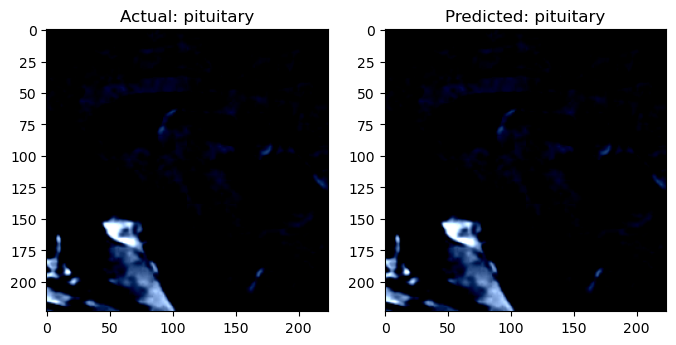

In [36]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Load the class names
class_names = dataset.classes

# Function to predict the class of an image
def predict_image(image, model, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Function to display image and prediction
def show_prediction(index, dataset, model, device):
    image, label = dataset[index]
    predicted_label = predict_image(image, model, device)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Actual: {class_names[label]}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Predicted: {class_names[predicted_label]}")
    
    plt.show()

# Select a random image from the test dataset and show the prediction
random_index = random.randint(0, len(test_dataset) - 1)
show_prediction(random_index, test_dataset, model, device)


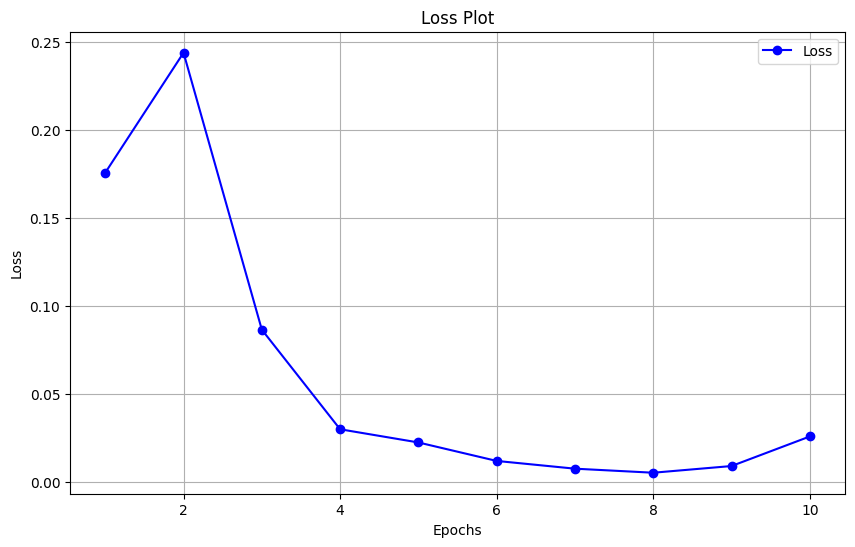

In [2]:
import matplotlib.pyplot as plt

# Sample loss values (replace with your actual loss values)
loss_values = [0.1757, 0.2439, 0.0865, 0.0299, 0.0224, 0.0119, 0.0075, 0.0052, 0.0090, 0.0258]

# Number of epochs or iterations
epochs = range(1, len(loss_values) + 1)

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'b-', marker='o', label='Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()